<a href="https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks/How_Input_Normalization_Changes_Our_Understanding_of_Interpolation_vs_Extrapolation_With_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture 
!pip install git+https://github.com/google/jaxopt

In [2]:
import jax 
import jax.numpy as jnp 
from functools import partial
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from jaxopt import OSQP

In [3]:
def sample_mean(key, c, d, cluster=True):
  subkey1, subkey2 = jax.random.split(key, 2)
  means = jnp.where(cluster, jax.random.multivariate_normal(key, mean=jnp.zeros((d,)), cov=jnp.eye(d), shape=(c,)),jnp.zeros(shape=(c, d)))
  return means 

def sample_from_gaussian(key, mean, cov, n) -> jnp.ndarray:
  samples = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(n,))
  return samples


print(sample_mean(jax.random.PRNGKey(0), c=3, d=4))
print(sample_mean(jax.random.PRNGKey(0), c=3, d=4, cluster=False))

[[ 1.1901639  -1.0996888   0.44367844  0.5984697 ]
 [-0.39189556  0.69261974  0.46018356 -2.068578  ]
 [-0.21438177 -0.9898306  -0.6789304   0.27362573]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [4]:
def cluster_sample(key_num, c, n, d, cluster=True):
  key = jax.random.PRNGKey(key_num)
  subkey1, subkey2 = jax.random.split(key)
  subkeys = jax.random.split(subkey2, c) # I shouldn't need to do this, I should be able to complete this in the line above!
  means = sample_mean(subkey1, c, d, cluster)
  cov = jnp.eye(d)  
  data = jax.vmap(sample_from_gaussian, in_axes=(0, 0, None, None))(subkeys, means, cov, n)
  training_data = data[:-1].reshape(-1, d)
  test_obs = data[-1][0]
  return training_data.T, test_obs

In [5]:
a, b = cluster_sample(0, 3, 3, 4)
print(a)

print(b)

[[ 2.4021628   1.244035   -1.5161334  -1.7480892   0.9220849   0.50444585]
 [ 2.8732383   1.3780229   0.80902475  0.17065549 -0.772181   -0.5290869 ]
 [-0.36620003  0.02749664 -1.526499   -0.2163448  -0.96507984 -1.0986922 ]
 [-1.2870091  -0.1996027   2.4274983   2.0855923  -0.07913542 -0.7216023 ]]
[-0.4189715   0.32702267 -0.06462672 -0.16329914]


In [6]:
def min_max_normalize(x, p):
  max = jnp.max(x, 1)
  min = jnp.min(x, 1)
  x = jax.vmap(lambda a, b, c: a-c/ (b-c), in_axes=(0,0,0))(x, max, min)
  p = (p-min)/(max-min)
  return x, p

In [7]:
def mean_sigma(x):
  return jnp.mean(x, 1, keepdims=True), jnp.std(x, 1, keepdims=True)

def mean_normalize(x, p):
  mu, sig = mean_sigma(x)
  x = (x - mu)/sig 
  p = (p - mu.reshape(-1,))/sig.reshape(-1,)
  return x, p

In [8]:
def Qcxp(key_num, c, n, d, cluster=True):
   n_ = (c-1)*n
   x, p = cluster_sample(key_num, c, n, d, cluster)
   return (1/n_)* jnp.matmul(x.T, x), -(1/n_)*jnp.dot(x.T,p), x, p

def Qcxp_norm(key_num, c, n, d, cluster=True):
   n_ = (c-1)*n
   x, p = cluster_sample(key_num, c, n, d, cluster)
   x, p = min_max_normalize(x, p)
   return (1/n_)* jnp.matmul(x.T, x), -(1/n_)*jnp.dot(x.T,p), x, p

def AbGh(c, n, d):
  n_ = (c-1)*n
  A = jnp.ones(shape=(1,n_))
  b = jnp.array([1.0]) 
  G = -1*jnp.eye(n_)
  h = jnp.zeros((n_,))
  return A, b, G, h

In [9]:
x = Qcxp(0, c=2, n=5, d=30)

In [10]:
@partial(jax.jit, static_argnums=(1,2,3,4))
def outside_convex_hull(key_num, c, n, d, cluster=True, tol=0.001):
  Q, m, x, p = Qcxp(key_num, c, n, d, cluster)
  A, b, G, h = AbGh(c, n, d)
  qp = OSQP()
  sol = qp.run(init_params=None, params_obj=(Q, m), params_eq=(A, b), params_ineq=(G, h)).params
  loss = jnp.mean((jnp.dot(x,sol.primal)-p)**2)
  return 1.*(loss>tol), loss

@partial(jax.jit, static_argnums=(1,2,3,4))
def outside_normalized_convex_hull(key_num, c, n, d, cluster=True, tol=0.001):
  Q, m, x, p = Qcxp_norm(key_num, c, n, d, cluster)
  A, b, G, h = AbGh(c, n, d)
  qp = OSQP()
  sol = qp.run(init_params=None, params_obj=(Q,m), params_eq=(A, b), params_ineq=(G, h)).params
  loss = jnp.mean((jnp.dot(x,sol.primal)-p)**2)
  return 1.*(loss>tol), loss

In [11]:
print(outside_convex_hull(0, c=51, n=10, d=3, cluster=True, tol=0.001))
print(outside_convex_hull(0, c=51, n=10, d=3, cluster=False, tol=0.001))

(DeviceArray(1., dtype=float32, weak_type=True), DeviceArray(0.35517043, dtype=float32))
(DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(9.917697e-06, dtype=float32))


In [12]:
print(outside_normalized_convex_hull(0, c=51, n=10, d=3, cluster=True, tol=0.001))
print(outside_normalized_convex_hull(0, c=51, n=10, d=3, cluster=False, tol=0.001))

(DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(7.232379e-10, dtype=float32))
(DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(7.0514383e-10, dtype=float32))


In [13]:
25*20

500

In [14]:
results1 = [] 
results2 = []
loop0 = list(range(2, 25, 2))
n = 25#10
c = 21 #51
for i in loop0:
  print(i)
  a, b = jax.vmap(outside_convex_hull, in_axes=(0, None, None, None))(jnp.arange(200), c, n, i)
  results1.append(1.-jnp.mean(a))
  a, b = jax.vmap(outside_convex_hull, in_axes=(0, None, None, None, None))(jnp.arange(200), c, n, i, False)
  results2.append(1.-jnp.mean(a))


2
4
6
8
10
12
14
16
18
20
22
24


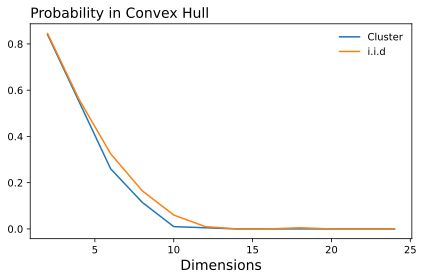

In [18]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(loop0, results1, label='Cluster')
plt.plot(loop0, results2, label='i.i.d')
plt.legend(frameon=False)
plt.xlabel('Dimensions', size=14)
plt.title('Probability in Convex Hull', loc='left', size=14)
fig.savefig('iid_cluster.pdf', format='pdf')
plt.show()

In [16]:
results11 = [] 
results12 = []
loop = list(range(10, 160, 10))
n = 25 #10
c = 21 #51
for i in loop:
  print(i)
  a, b = jax.vmap(outside_normalized_convex_hull, in_axes=(0, None, None, None))(jnp.arange(200), c, n, i)
  results11.append(1.-jnp.mean(a))
  a, b = jax.vmap(outside_normalized_convex_hull, in_axes=(0, None, None, None, None))(jnp.arange(200), c, n, i, False)
  results12.append(1.-jnp.mean(a))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


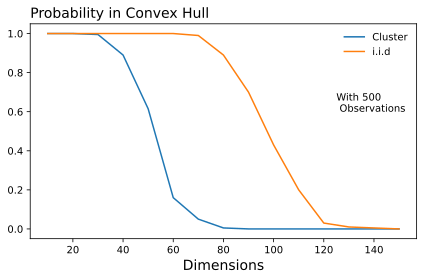

In [17]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(loop, results11, label='Cluster')
plt.plot(loop, results12, label='i.i.d')
plt.legend(frameon=False)
plt.xlabel('Dimensions', size=14)
plt.title('Probability in Convex Hull', loc='left', size=14)
plt.text(125, .6, "With 500\n Observations") 
fig.savefig('Impact_of_normalization_iid_cluster.pdf', format='pdf')
plt.show()